In [1]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

2024-03-02 15:46:56.901892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 15:46:56.901982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 15:46:57.031742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
np.random.seed(12049)

In [3]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

In [4]:
def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

In [5]:
def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [6]:
base_dir = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

In [7]:
model_name = "Inception ResNet V2"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')

In [8]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
)

In [9]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [10]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [11]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [12]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [13]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

219055592/219055592 [==============================] - 7s 0us/step


In [14]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 54283877 (207.08 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [15]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100


I0000 00:00:1709394500.641745     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 [==============================] - 211s 683ms/step - loss: 1.1817 - accuracy: 0.4271 - val_loss: 6.6302 - val_accuracy: 0.0593 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - 79s 434ms/step - loss: 0.9306 - accuracy: 0.5325 - val_loss: 1.1873 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - 80s 438ms/step - loss: 0.8343 - accuracy: 0.5756 - val_loss: 1.0263 - val_accuracy: 0.5460 - lr: 0.0010
Epoch 4/100
181/181 [==============================] - 79s 436ms/step - loss: 0.8073 - accuracy: 0.5919 - val_loss: 1.6632 - val_accuracy: 0.5351 - lr: 0.0010
Epoch 5/100
181/181 [==============================] - 79s 433ms/step - loss: 0.7851 - accuracy: 0.6049 - val_loss: 1.0993 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 6/100
181/181 [==============================] - 81s 445ms/step - loss: 0.7388 - accuracy: 0.6265 - val_loss: 0.9695 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 7/100
181/181 [==============================] - 81

In [16]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model Inception ResNet V2 fine tuning executed in 39.36 minutes


In [17]:
tf.keras.saving.get_custom_objects().clear()


# Upon registration, you can optionally specify a package or a name.
# If left blank, the package defaults to `Custom` and the name defaults to
# the class name.
@tf.keras.saving.register_keras_serializable(package="MyLayers")
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}


@tf.keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def custom_fn(x):
    return x**2

In [18]:
# Assuming your model is named 'model'
model_ft.save('Custom_Inception_ResNet_v2.keras')


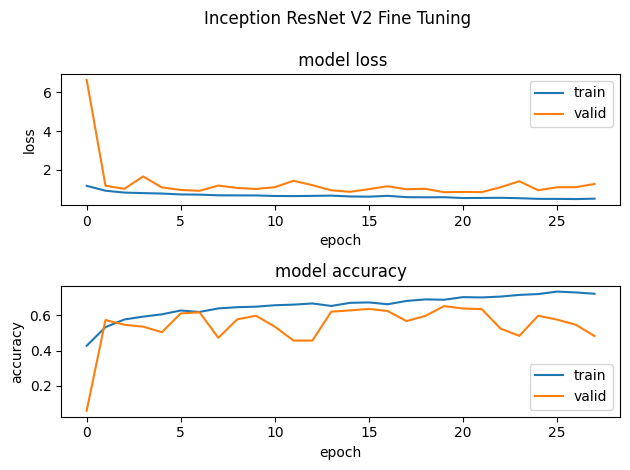

In [19]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [20]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 3s 105ms/step - loss: 0.8536 - accuracy: 0.6513
Valid loss: 0.85
Valid accuracy: 0.65


In [21]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 6s 98ms/step
Accuracy Score - Inception ResNet V2: 0.65
Balanced Accuracy Score - Inception ResNet V2: 0.67


              precision    recall  f1-score   support

           0       0.73      0.82      0.77       328
           1       0.38      0.23      0.29       153
           2       0.64      0.57      0.60       212
           3       0.62      0.84      0.71       106
           4       0.83      0.89      0.86        27

    accuracy                           0.65       826
   macro avg       0.64      0.67      0.65       826
weighted avg       0.63      0.65      0.63       826



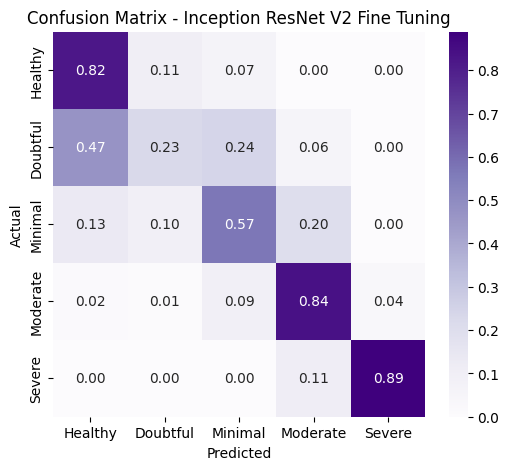

In [22]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [1]:
import os
import timeit

import tensorflow as tf
from tensorflow import keras 

2024-03-10 10:53:38.036496: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 10:53:38.038212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 10:53:38.096568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 10:53:38.098375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 10:53:39.187226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, sublayer, **kwargs):
        super().__init__(**kwargs)
        self.sublayer = sublayer

    def call(self, x):
        return self.sublayer(x)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "sublayer": keras.saving.serialize_keras_object(self.sublayer),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)





# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()


# Upon registration, you can optionally specify a package or a name.
# If left blank, the package defaults to `Custom` and the name defaults to
# the class name.
@keras.saving.register_keras_serializable(package="MyLayers")
class CustomLayer(keras.layers.Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}


@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def custom_fn(x):
    return x**2


# Create the model.
def get_model():
    inputs = keras.Input(shape=(4,))
    mid = CustomLayer(0.5)(inputs)
    outputs = keras.layers.Dense(1, activation=custom_fn)(mid)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mean_squared_error")
    return model


# # Train the model.
# def train_model(model):
#     input = np.random.random((4, 4))
#     target = np.random.random((4, 1))
#     model.fit(input, target)
#     return model


# test_input = np.random.random((4, 4))
# test_target = np.random.random((4, 1))

# model = get_model()
# model = train_model(model)
# model.save("custom_model.keras")

# Now, we can simply load without worrying about our custom objects.
reconstructed_model = keras.models.load_model("/home/dipak/Documents/Knee-OA-detection/src/models/Custom_Inception_ResNet_v2.keras")

# # Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )


In [ ]:
import cv2
import numpy as np
image_path = '/home/dipak/Documents/Knee-OA-detection/Dataset/4/9057150L.png'
image = cv2.imread(image_path)

processed_image = np.expand_dims(image, axis=0)
predictions = reconstructed_model.predict(processed_image)

In [ ]:
predictions